In [35]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [36]:
pattern_size = (6, 8)

pattern_points = np.zeros((np.prod(pattern_size), 2), np.float64)
pattern_points[:, :] = np.indices(pattern_size).T.reshape(-1, 2)



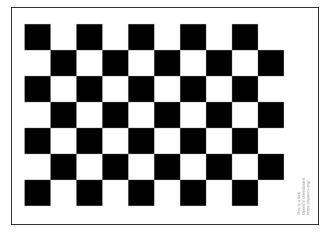

In [37]:
pattern_image = cv.imread('pattern.png')
plt.imshow(pattern_image)
plt.xticks([]), plt.yticks([])
plt.show()


In [ ]:
status, corners = cv.findChessboardCorners(pattern_image, (6, 9))
if status:
    #print(corners)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_COUNT, 300, 0.01)
    cv.cornerSubPix(pattern_image, corners, (5, 5), (-1, -1), criteria)
else:
    print("Could not detect corners")